In [46]:
import pandas as pd
import numpy as np
from common import *
from glob import glob
from os import rename, path
from gensim import corpora
from os.path import basename

from matplotlib import pyplot as plt

import gensim
from gensim import corpora, models, similarities

DATA_FOLDER = '../data/'

In [55]:
%%time
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'old.dict'))
corpus = corpora.MmCorpus(join(DATA_FOLDER, 'corpus.mm'))

CPU times: user 2.3 s, sys: 352 ms, total: 2.65 s
Wall time: 2.69 s


In [56]:
print(corpus)

MmCorpus(1194664 documents, 3496816 features, 192260021 non-zero entries)


In [57]:
%%time
fmodel = join(DATA_FOLDER, 'tfidf.model')
if not path.exists(fmodel):    
    tfidf = models.TfidfModel(corpus)
    tfidf.save(fmodel)
else:
    tfidf = models.TfidfModel.load(fmodel)

CPU times: user 532 ms, sys: 220 ms, total: 752 ms
Wall time: 752 ms


In [58]:
# %%time
# index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=len(dictionary), num_best=200)

In [59]:
%%time
fname = join(DATA_FOLDER, 'sim_index/sim')
if not exists(fname):
    index = similarities.Similarity(fname, tfidf[corpus], 
                                    num_features=len(dictionary), num_best=200, 
                                    chunksize=4*256, shardsize=5*32768)
    index.save(fname)
else:
    index = similarities.Similarity.load(fname)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 638 µs


### Test all

In [60]:
with open(join(DATA_FOLDER, 'gold.txt'), 'r') as f:
    gold_txt = f.read()
lines = gold_txt.splitlines()
gold = {line.split()[0]:line.split()[1:] for line in lines}

In [8]:
# DATA_FOLDER = '../data/'
# test_docs = []
# for root, directories, filenames in os.walk(join(DATA_FOLDER, 'FIPS/test/')):
#     test_docs += [join(root,f) for f in filenames]

In [9]:
# for f in test_docs:
#     if not '.txt' in f:
#         rename(f, f + '.txt')

In [61]:
test_docs = glob(join(DATA_FOLDER, 'docs/*.txt'))

In [62]:
preds = {}
for fname in test_docs:
    with open(fname, 'r') as f:
        doc_text = f.read()
    vec_bow = dictionary.doc2bow(tokenize(doc_text))
    vec_model = tfidf[vec_bow] # convert the query to model space
    preds[path.splitext(basename(fname))[0]] = index[vec_model]

In [63]:
%%time
all_docs = get_all_docs(DATA_FOLDER)

CPU times: user 168 ms, sys: 120 ms, total: 288 ms
Wall time: 285 ms


In [64]:
# preds['0a3e021a-fc69-c9f3-5697-0474cf3d03de']

In [65]:
all_docs[31217]

'../data/FIPS/Inventions patents_txt_output/cd/5f/0002338697C220081120RU.txt'

In [70]:
new_pred = {}
for k, v in preds.items():
    new_pred[k] = [path.splitext(basename(all_docs[key]))[0] for key, sim in v]

In [71]:
# new_pred['e75dcef9-73b5-40c1-45be-33a191b6440c']

In [72]:
result = []
for key, val in new_pred.items():
    true_val = gold[key]
    gold_len = len(true_val)
    
    inter10 = set(val[0:10]).intersection(true_val)
    inter20 = set(val[0:20]).intersection(true_val)
    inter200 = set(val[0:200]).intersection(true_val)
    
    acc10 = len(inter10)/gold_len
    acc20 = len(inter20)/gold_len
    acc200 = len(inter200)/gold_len
    
    result.append([acc10, acc20, acc200])

result = pd.DataFrame(result, columns=['acc10', 'acc20', 'acc200'])
print(result.median(axis=0))
print(result.mean(axis=0))

acc10     0.333333
acc20     0.500000
acc200    1.000000
dtype: float64
acc10     0.437730
acc20     0.516871
acc200    0.758078
dtype: float64


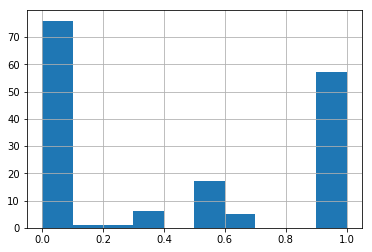

In [73]:
result['acc10'].hist()
plt.show()

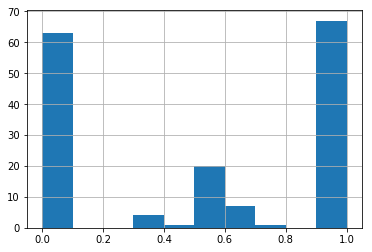

In [74]:
result['acc20'].hist()
plt.show()

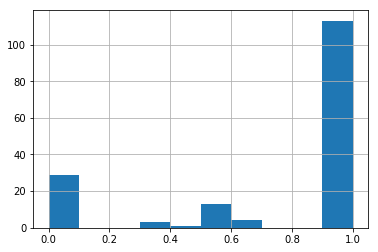

In [75]:
result['acc200'].hist()
plt.show()

In [154]:
len([v for v in all_docs if '-' in v])

241

### Test 3


In [29]:
%%time
dictionary = corpora.Dictionary.load(join(DATA_FOLDER, 'filtered.dict'))
corpus = corpora.MmCorpus(join(DATA_FOLDER, 'filtered_corpus.mm'))

CPU times: user 580 ms, sys: 68 ms, total: 648 ms
Wall time: 647 ms


In [30]:
print(corpus)

MmCorpus(1194664 documents, 843052 features, 187315959 non-zero entries)


In [31]:
%%time
fmodel = join(DATA_FOLDER, 'tfidf_filtered.model')
if not path.exists(fmodel):    
    tfidf = models.TfidfModel(corpus)
    tfidf.save(fmodel)
else:
    tfidf = models.TfidfModel.load(fmodel)

CPU times: user 8min 32s, sys: 1.53 s, total: 8min 34s
Wall time: 8min 34s


In [32]:
%%time
fname = join(DATA_FOLDER, 'sim_index3/sim')
if not exists(fname):
    index = similarities.Similarity(fname, tfidf[corpus], 
                                    num_features=len(dictionary), num_best=200, 
                                    chunksize=4*256, shardsize=5*32768)
    index.save(fname)
else:
    index = similarities.Similarity.load(fname)

CPU times: user 23min 31s, sys: 3.74 s, total: 23min 34s
Wall time: 23min 34s


In [33]:
preds = {}
for fname in test_docs:
    with open(fname, 'r') as f:
        doc_text = f.read()
    vec_bow = dictionary.doc2bow(tokenize(doc_text))
    vec_model = tfidf[vec_bow] # convert the query to model space
    preds[path.splitext(basename(fname))[0]] = index[vec_model]

In [34]:
new_pred = {}
for k, v in preds.items():
    new_pred[k] = [path.splitext(basename(all_docs[key]))[0] for key, sim in v]

In [52]:
result = []
for key, val in new_pred.items():
    true_val = gold[key]
    gold_len = len(true_val)
    
    inter10 = set(val[0:10]).intersection(true_val)
    inter20 = set(val[0:20]).intersection(true_val)
    inter200 = set(val[0:200]).intersection(true_val)
    
    acc10 = len(inter10)/gold_len
    acc20 = len(inter20)/gold_len
    acc200 = len(inter200)/gold_len
    
    result.append([acc10, acc20, acc200])

result = pd.DataFrame(result, columns=['acc10', 'acc20', 'acc200'])
print(result.median(axis=0))
print(result.mean(axis=0))

acc10     0.333333
acc20     0.500000
acc200    1.000000
dtype: float64
acc10     0.435685
acc20     0.516871
acc200    0.745808
dtype: float64


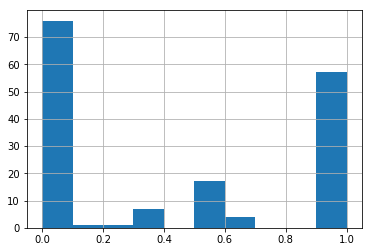

In [48]:
result['acc10'].hist()
plt.show()

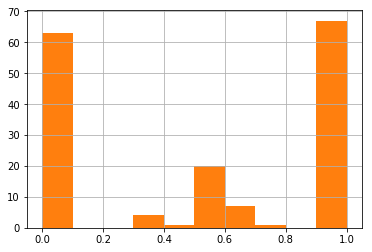

In [50]:
result['acc20'].hist()
plt.show()

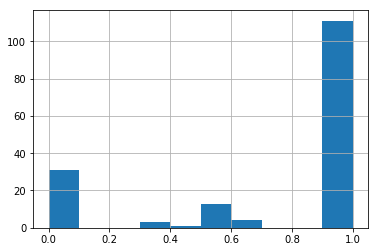

In [51]:
result['acc200'].hist()
plt.show()